In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
for Class in Base.classes.keys():
    print(Class)

measurement
station


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# some classes to display queries
def print_query(query):
    """
    Display all the variables in the item query.
    
        query -- A query, which in this case could be a class instance or a collection of class instances as a sqlalchemy.orm.query.Query.
    """
    if type(query) is sqlalchemy.orm.query.Query:
        for item in query:
            print_query(item)
    else:
        for key, value in query.__dict__.items():
            if not key.startswith("_"):
                print(f'{key} : {value}')

In [10]:
# Display some starter data
print_query(session.query(Measurement).first())
print_query(session.query(Station).limit(1))

prcp : 0.08
tobs : 65.0
id : 1
station : USC00519397
date : 2010-01-01
latitude : 21.2716
station : USC00519397
longitude : -157.8168
name : WAIKIKI 717.2, HI US
id : 1
elevation : 3.0


## Bonus Challenge Assignment: Temperature Analysis II

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [12]:
trip_year = 2015
print(f"Selected year is {trip_year}")

Selected year is 2015


In [13]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
date_min, date_max = session.query(func.min(Measurement.date), func.max(Measurement.date)).first()
years_range = list(range(int(date_min[:4]), int(date_max[:4])))
tmin, tavg, tmax = calc_temps(f"{trip_year}-01-01", f"{trip_year}-12-31")[0]
print(f"{trip_year} - tmin: {round(tmin,2)}, tavg: {round(tavg,2)}, tmax: {round(tmax,2)}")

2015 - tmin: 56.0, tavg: 73.86, tmax: 86.0


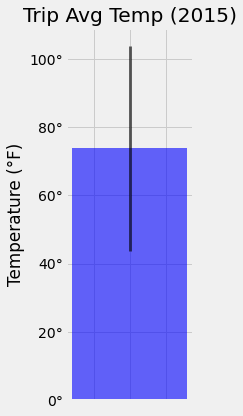

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(1, 1, figsize = (3, 6))
plt.errorbar(
    x = 0, 
    y = tavg,
    yerr = tmax - tmin,
    elinewidth=3,
    color = "black",
    alpha = 0.6
)

plt.bar(
    x = 0, 
    height = tavg,
    color = "blue",
    alpha = 0.6
)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('')) 
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}°'))
plt.title(f"Trip Avg Temp ({trip_year})")
plt.xlabel('')
plt.ylabel('Temperature (°F)')
plt.tight_layout()
plt.savefig(f'Images/bonus_2_trip_avg_temp_{trip_year}.png', bbox_inches = "tight")
plt.show()

### Daily Rainfall Average

In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
amount_of_rainfall_per_weather_station = session.query(
    func.sum(Measurement.prcp), 
    Station.station, 
    Station.name, 
    Station.latitude, 
    Station.longitude, 
    Station.elevation
).join(Measurement, Measurement.station == Station.station).\
group_by(Measurement.station).\
filter(
    Measurement.date >= func.DATE(f"{trip_year-1}-01-01"),
    Measurement.date <= func.DATE(f"{trip_year-1}-12-31")
).order_by(func.sum(Measurement.prcp).desc())

for weather_station in amount_of_rainfall_per_weather_station:
    prcp_sum, station, name, lat, lng, elevation = weather_station
    print(f"{round(prcp_sum, 2)}\ttotal amount of rainfall")
    print(f"\tlatitude: {round(lat, 2)}, longitude: {round(lng, 2)}, elevation: {round(elevation, 2)}")
    print(f"\tweather station: {station} - {name}")
    print()

144.55	total amount of rainfall
	latitude: 21.33, longitude: -157.8, elevation: 152.4
	weather station: USC00516128 - MANOA LYON ARBO 785.2, HI US

89.85	total amount of rainfall
	latitude: 21.45, longitude: -157.85, elevation: 32.9
	weather station: USC00519281 - WAIHEE 837.5, HI US

58.41	total amount of rainfall
	latitude: 21.42, longitude: -157.8, elevation: 14.6
	weather station: USC00513117 - KANEOHE 838.1, HI US

45.93	total amount of rainfall
	latitude: 21.34, longitude: -157.71, elevation: 19.5
	weather station: USC00519523 - WAIMANALO EXPERIMENTAL FARM, HI US

39.31	total amount of rainfall
	latitude: 21.52, longitude: -157.84, elevation: 7.0
	weather station: USC00514830 - KUALOA RANCH HEADQUARTERS 886.9, HI US

21.94	total amount of rainfall
	latitude: 21.32, longitude: -158.0, elevation: 0.9
	weather station: USC00511918 - HONOLULU OBSERVATORY 702.2, HI US

21.19	total amount of rainfall
	latitude: 21.27, longitude: -157.82, elevation: 3.0
	weather station: USC00519397 - W

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [17]:
datetime_format = "%Y-%m-%d"

trip_month = 7
trip_starting_day = 16
trip_length = 12

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
trip_dates = [f"{trip_month:02d}-{day:02d}" for day in list(range(trip_starting_day, trip_starting_day + trip_length))]

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for day in trip_dates:
    normals.append(daily_normals(day)[0])

# Set the start and end date of the trip
start_date = f'{trip_year}-{trip_dates[0]}'
end_date = f'{trip_year}-{trip_dates[-1]}'

In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({
    "date" : [f"{trip_year}-{day}" for day in trip_dates],
    "Temperature Min" : [tmin for tmin, tavg, tmax in normals], 
    "Temperature Average" : [tavg for tmin, tavg, tmax in normals], 
    "Temperature Max" : [tmax for tmin, tavg, tmax in normals]
})
df["date"] = pd.to_datetime(df["date"], format=datetime_format)
df.set_index("date", inplace=True)
df

,Temperature Min,Temperature Average,Temperature Max
date,,,
2015-07-16,70.0,76.344828,83.0
2015-07-17,70.0,76.301887,83.0
2015-07-18,72.0,76.637931,83.0
2015-07-19,68.0,75.890909,83.0
2015-07-20,69.0,75.462963,82.0
2015-07-21,69.0,76.924528,83.0
2015-07-22,69.0,75.788462,81.0
2015-07-23,70.0,76.203704,84.0
2015-07-24,69.0,76.555556,81.0


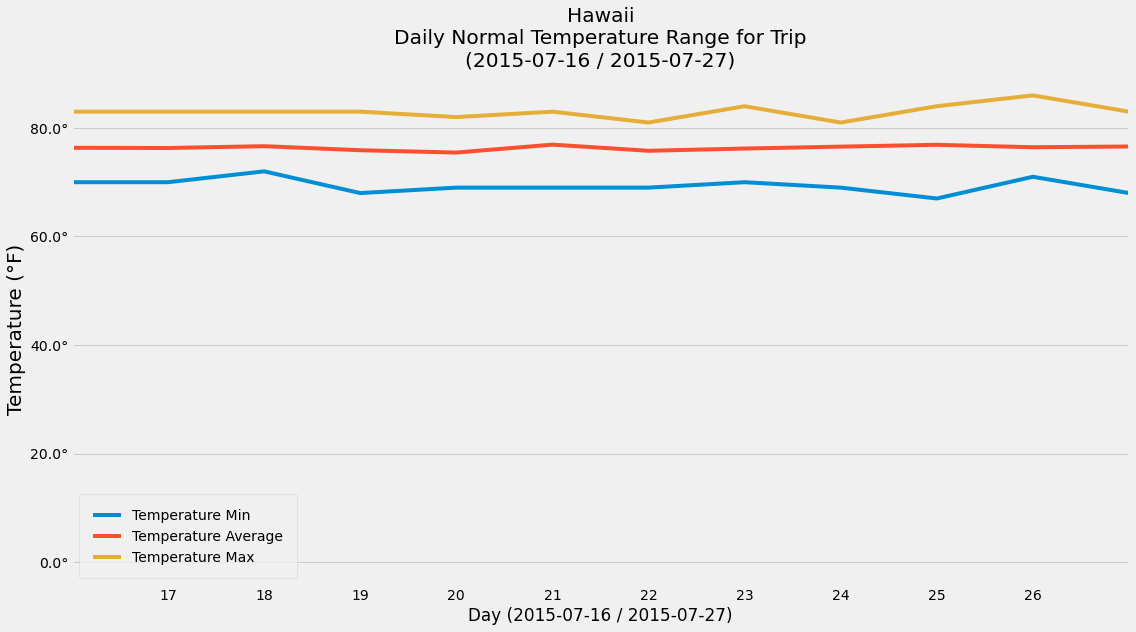

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(1, 1, figsize = (16,9))
df.plot(
    ax=ax,
    stacked=False
)
ax.fill_between(df["Temperature Max"].values, 0, alpha=1)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('')) 
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.01f}°')) 
ax.legend(
    loc='lower left', 
    borderpad =1
)
plt.title(f'Hawaii\nDaily Normal Temperature Range for Trip\n({start_date} / {end_date})')
plt.xlabel(f'Day ({start_date} / {end_date})')
plt.ylabel('Temperature (°F)', fontsize = (20))
plt.tight_layout()
plt.savefig('Images/daily_normal_temperature_range_for_trip.png', bbox_inches = "tight")
plt.show()

## Close Session

In [20]:
# Close Session
session.close()